## Timeseries analysis of the evolution of sponsoring domains in videos

In [1]:
import findspark
findspark.init()

import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

import numpy as np
import seaborn as sns
import pandas as pd

from pyspark.sql.functions import explode, udf, count, collect_list
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, LongType, StringType, DateType, ArrayType, BooleanType, FloatType

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm

from pyspark.sql import SparkSession
import pyspark
import pyspark.pandas as ps
config = pyspark.SparkConf()
config.set('spark.executor.heartbeatInterval', '3600s')
config.set('spark.network.timeout', '7200s')
config.set('spark.driver.memory', '16g')
sc = pyspark.SparkContext('local[*]', '', conf=config) # write 'local' for single-threaded execution and 'local[*]' for multi-threaded execution
spark = SparkSession(sc)

ps.set_option("plotting.backend", "matplotlib")

plt.style.use('ggplot')

In [2]:
def str2list(x):
    """Function used to cast a string list into the ArrayType(StringType()) type of PySaprk.

    Args:
        x: the column to be casted

    Returns:
        the casted column
    """
    if x == '[]':
        return list()
    else:
        return x.replace('[', '').replace(']', '').split(',')
    
str2list_udf = udf(str2list, ArrayType(StringType()))

In [160]:
PATH_METADATAS_DOMAINS_SRC = '../data/generated/yt_metadata_sponsor_en_domains.parquet'
PATH_DOMAINS = '../data/generated/yt_metadata_en_domains.parquet'
PATH_SPONSORS = '../data/domains_classification.csv'

schema_metadatas_domains = StructType([
    StructField("display_id",    StringType(),            True),
    StructField("domains",       ArrayType(StringType()), True),
    StructField("domains_count", IntegerType(),           True),
    StructField("is_sponsored",  BooleanType(),           True)
])
schema_domain_metadatas = StructType([
    StructField("categories",    StringType(),            True),
    StructField("channel_id",    StringType(),            True),
    StructField("dislike_count", DoubleType(),            True), # This field must be specified as a double as it is represented as a floating point number
    StructField("display_id",    StringType(),            True),
    StructField("duration",      IntegerType(),           True),
    StructField("like_count",    DoubleType(),            True), # This field must be specified as a double as it is represented as a floating point number
    StructField("tags",          StringType(),            True),
    StructField("title",         StringType(),            True),
    StructField("upload_date",   DateType(),              True),
    StructField("view_count",    DoubleType(),            True),  # This field must be specified as a double as it is represented as a floating point number
    StructField("domains",       ArrayType(StringType()), True), 
    StructField("domains_count", IntegerType(),           True),
    StructField("has_domains",   BooleanType(),           True),
])

# Read the required files
domain_metadatas = spark.read.parquet(PATH_METADATAS_DOMAINS_SRC, schema=schema_metadatas_domains)
domains = spark.read.parquet(PATH_DOMAINS, schema=schema_domain_metadatas)
sponsors = spark.read.csv(PATH_SPONSORS, header=True, inferSchema=True)

# And cast the columns to the appropriate types
domain = domains \
    .withColumn("dislike_count", domains.dislike_count.cast(IntegerType())) \
    .withColumn("like_count", domains.like_count.cast(IntegerType())) \
    .withColumn("view_count", domains.view_count.cast(LongType())) \

domain_metadatas = domain_metadatas \
      .withColumn("domain_categories", str2list_udf(domain_metadatas.domain_categories))

sponsors = sponsors \
    .withColumn("is_sponsored", sponsors.is_sponsored.cast(BooleanType()))

(domain_metadatas.dtypes, domains.dtypes, sponsors.dtypes)

([('display_id', 'string'),
  ('domains', 'array<string>'),
  ('domain_categories', 'array<string>'),
  ('is_sponsored', 'boolean')],
 [('categories', 'string'),
  ('channel_id', 'string'),
  ('dislike_count', 'int'),
  ('display_id', 'string'),
  ('duration', 'int'),
  ('like_count', 'int'),
  ('tags', 'string'),
  ('title', 'string'),
  ('upload_date', 'date'),
  ('view_count', 'bigint'),
  ('domains', 'array<string>'),
  ('domains_count', 'int'),
  ('has_domains', 'string')],
 [('domain', 'string'),
  ('count', 'int'),
  ('median_sponsor_score', 'double'),
  ('is_sponsored', 'boolean'),
  ('domain_category', 'string')])

### Evolution of rstyle.me and play.google.com

In [161]:
# We join domain_metadatas and domains with display_id
# but only take columns in domains that are not in domain_metadatas
videos = domain_metadatas \
    .join(
        domains.select(
            'display_id',
            'channel_id',
            'title',
            'upload_date',
            'duration',
            'view_count',
            'like_count',
            'dislike_count',
            'tags'),
        on='display_id', how='inner'
    )

In [162]:
# We explode the domains column to get a row of video per domain and join with sponsors
# to get the category of each domain
# We then replace the None values of is_sponsored with False
# Finally, we drop duplicated lines
videos = videos \
    .drop('domain_categories', "is_sponsored") \
    .withColumn('domain', explode('domains')) \
    .drop('domains') \
    .join(sponsors.select("domain", "is_sponsored", "domain_category"), on='domain', how='left') \
    .na.fill(False, subset=['is_sponsored']) \
    .dropDuplicates()

In [163]:
# Create a column months that contains the year and the month of the upload_date and cast it to a date
videos = videos \
    .withColumn('month', videos.upload_date.substr(1, 7).cast(DateType()))

In [164]:
videos.dtypes

[('domain', 'string'),
 ('display_id', 'string'),
 ('channel_id', 'string'),
 ('title', 'string'),
 ('upload_date', 'date'),
 ('duration', 'int'),
 ('view_count', 'bigint'),
 ('like_count', 'int'),
 ('dislike_count', 'int'),
 ('tags', 'string'),
 ('is_sponsored', 'boolean'),
 ('domain_category', 'string'),
 ('month', 'date')]

In [167]:
# We only get the videos that are sponsored and contain rsteyle.me or play.google.com in their domain
videos_cnt = (videos
        .filter((videos.is_sponsored) & ((videos.domain == "rstyle.me") | (videos.domain == "play.google.com"))).persist()
        .pandas_api()
        .groupby(['month', "domain"])
        .size()
        .reset_index()
        .sort_index()
        .rename(columns={0: "count"})
)
videos_cnt.dtypes

month     datetime64[ns]
domain            object
count              int64
dtype: object

In [9]:
videos_cnt.head(10)

,month,domain,count
0,2018-11-01,play.google.com,53160
1,2016-11-01,play.google.com,18004
2,2018-07-01,rstyle.me,2741
3,2014-11-01,play.google.com,5227
4,2018-01-01,rstyle.me,2641
5,2010-06-01,play.google.com,837
6,2016-08-01,play.google.com,15855
7,2014-01-01,play.google.com,2529
8,2018-08-01,rstyle.me,2770
9,2016-11-01,rstyle.me,1539


In [10]:
# Transpose the domain column to get a column for each domain to plot them later
videos_cnt_t = videos_cnt.pivot(index='month', columns='domain', values='count').sort_index().fillna(0)
videos_cnt_t.head(10)

domain,play.google.com,rstyle.me
month,,
2006-03-01,6,0
2006-06-01,2,0
2006-07-01,3,0
2006-08-01,4,0
2006-09-01,8,0
2006-10-01,5,0
2006-11-01,4,0
2006-12-01,3,0
2007-01-01,9,0


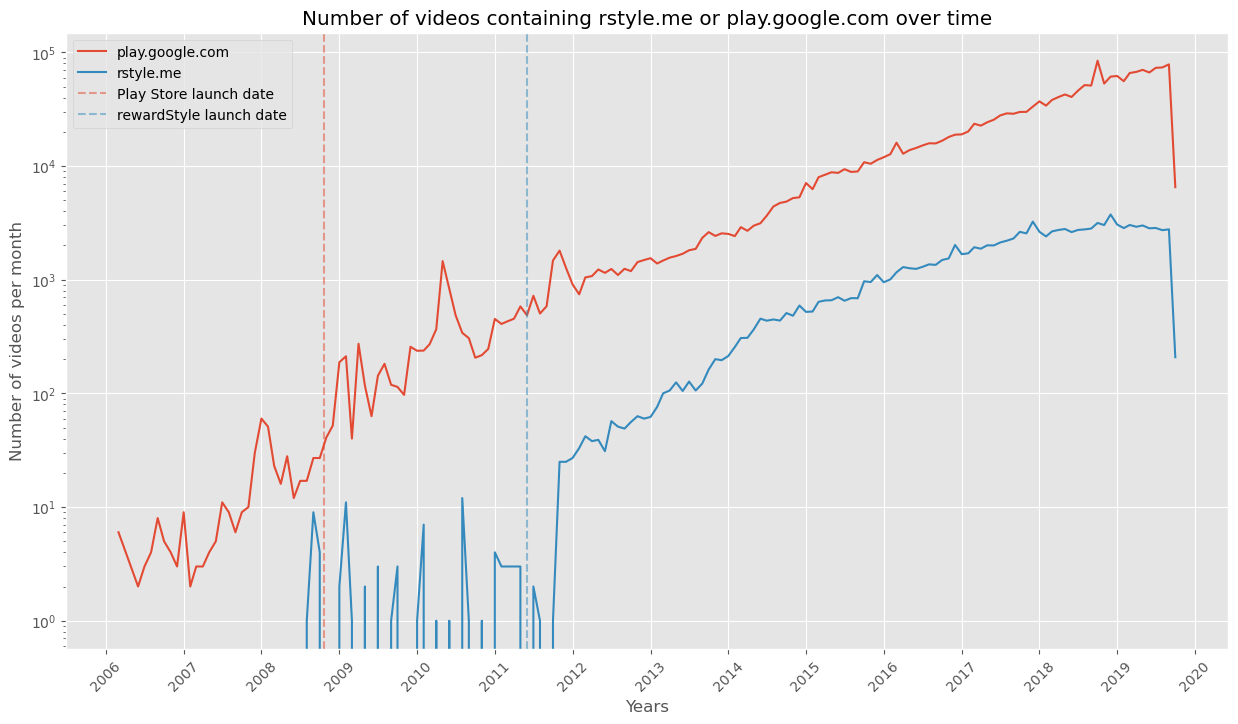

In [11]:
# Plot the number of videos that contain this domain over each month
videos_cnt_t.plot.line(figsize=(15, 8))
plt.title("Number of videos containing rstyle.me or play.google.com over time")
plt.xlabel("Years")
plt.ylabel("Number of videos per month")
plt.yscale("log")
# Plot a red line at 2008-10-22 as it is the start of the Play Store
plt.axvline(x='2008-10-22', color='C0', linestyle='--', label='Play Store launch date', alpha=0.5)
# Plot a blue line at 2011-06-01 as it is the start of renweStyle
plt.axvline(x='2011-06-01', color='C1', linestyle='--', label='rewardStyle launch date', alpha=0.5)
# Show each year on the x-axis as dates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.legend()
plt.show()

We can see that videos mentioning rewardStyle (rstyle.me) appeared around $2008$ whereas the ones mentioning the Google Play Store (play.google.com) appeared around $2006$. We can also see that rewardStyle starts in a rather rough manner. Indeed, there are multiple months where no videos mention the domain after its first appearance before it starts to get mentioned on a regular basis after the end of $2011$. The same cannot be said for the Google Play. It is mentioned on videos from the very beginning and on a regular basis. \
We can also see that the number of videos posted every months for both increase exponentially after $2012$. \
It is interessting to note that the Google Play Store was officially launched on the [$22\text{nd of Octobre }2008$](https://en.wikipedia.org/wiki/Google_Play), so it is rather surprising to see videos mentioning it before that date. We will explore this a bit further in the following cells bellow. \
We can say the same abount rewardStyle. According to [crunchbase.com](https://www.crunchbase.com/organization/rewardstyle), the company was founded on the $\text{1st of June }2011$. 
We will explore this a bit further in the following cells bellow.

In [12]:
# Get videos that are sponsored by play.google.com that are before 2008-10-22
play_videos = videos \
    .filter((videos.is_sponsored) & (videos.domain == "play.google.com") & (videos.upload_date < "2008-10-22")) \
    .pandas_api()
print(f"The number of videos mentioning play.google.com before 2008-10-22 is {play_videos.shape[0]}.")
play_videos.head(10)

The number of videos mentioning play.google.com before 2008-10-22 is 407.


,domain,display_id,channel_id,title,upload_date,duration,view_count,like_count,dislike_count,tags,is_sponsored,domain_category,month
0,play.google.com,2bFS3hjS8oo,UCKkq4T-M1hYpptJRZwdxTJA,Zuby Raps About Oxford University Student Life,2006-11-21,77,11215,42,5,"zuby,oxford,oxford rap,oxford rapper,oxford un...",True,Application,2006-11-01
1,play.google.com,8bGYF5h2IJs,UCVNoZyj0kA8YL1X9flCVlxQ,"Alexander O'Neal ft. Russell Watson - ""To All ...",2008-06-06,233,4889,11,0,"Russell Watson,To All The Girls I've Loved Bef...",True,Application,2008-06-01
2,play.google.com,DYgoWQbPrHA,UC-SGiJ6GQ0i6cvEqbl293xg,Ryan Farish - Road To You (Official Video),2007-12-12,237,55857,255,8,"Ryan Farish,Road to You,Official Video,Video,R...",True,Application,2007-12-01
3,play.google.com,IZRhrPcTVJo,UCVKca2tBe83V9GR5f-YnW6g,Brazilian Jiu Jitsu | Training Log May 2007 | ...,2007-05-28,157,3981,6,1,"BJJ,grappling,roy,dean,jujutsu,brazilian,jiu,j...",True,Application,2007-05-01
4,play.google.com,J-LqLU7CxeA,UCoMdktPbSTixAyNGwb-UYkQ,Builder Demolishes His Work After Pay Dispute ...,2008-04-23,115,5779450,23555,1799,"sky,news,builder,pay,dispute,demolish,home,ham...",True,Application,2008-04-01
5,play.google.com,WsXLQZpqWTA,UCmdQ5iTjEF2tZTfU-pTa2aQ,Mini ortoGig,2006-09-05,875,28736,241,20,"ortopilot,live,video,gig,acoustic,band,album,p...",True,Application,2006-09-01
6,play.google.com,hKFfYr7at9s,UC5VYrVnw-v9UPN75q6ckGIg,K-Ci and Jojo - All My Life - Acoustic w/ Chlo...,2008-01-04,140,946681,3372,357,"davidchoimusic,david,choi,K-Ci,and,Jojo,All,My...",True,Application,2008-01-01
7,play.google.com,mg6XxcT4l7c,UCQ3LBcZNzPIAJv1ktEB8Y6g,Fuel Tank Level Sensor,2008-01-26,161,234575,202,34,"Fuel level,auto diagnostic,scanner,sensor,OBD ...",True,Application,2008-01-01
8,play.google.com,nb6mEPc4X18,UCVNoZyj0kA8YL1X9flCVlxQ,Alexander O'Neal & Mica Paris on GMTV's Lorrai...,2008-01-17,302,2622,6,0,"Mica Paris,Alexander O'Neal,Alexander ONeal,Al...",True,Application,2008-01-01
9,play.google.com,qC6QQ3T6ULA,UCQ3LBcZNzPIAJv1ktEB8Y6g,Scanning LOAD Parameter,2008-01-26,79,4021,9,0,"parameter,load,OBD II PID,Scanner,Automotive,s...",True,Application,2008-01-01


In [13]:
# Get videos that are sponsored by rstyle.me that are before 2011-06-01
style_videos = videos \
    .filter((videos.is_sponsored) & (videos.domain == "rstyle.me") & (videos.upload_date < "2011-06-01")) \
    .pandas_api()
print(f"The number of videos mentioning play.google.com before 2011-06-01 is {style_videos.shape[0]}.")
style_videos.head(10)

The number of videos mentioning play.google.com before 2011-06-01 is 77.


,domain,display_id,channel_id,title,upload_date,duration,view_count,like_count,dislike_count,tags,is_sponsored,domain_category,month
0,rstyle.me,LbYJD0wioaE,UCNnnebGhmIJ8MQ4X1HwphRw,Disney Dream: Minnie Mouse,2011-01-25,93,3486,6,0,"Disney,Dream,Minnie,Mouse",True,Agency,2011-01-01
1,rstyle.me,P869tcmaNXU,UCNnnebGhmIJ8MQ4X1HwphRw,Best Beauty Salon 2010 Hoodie Award Winner,2010-08-31,152,22042,33,2,"Wendy Raquel Robinson,best beauty salon,tampa,...",True,Agency,2010-08-01
2,rstyle.me,yxKXZVt4wxM,UCNnnebGhmIJ8MQ4X1HwphRw,Steve Harvey Rips Bill O'Reilly Part 2,2009-07-10,354,29135,241,6,"steve harvey,michael jackson,bill oreilly,raci...",True,Agency,2009-07-01
3,rstyle.me,bHVOxhEpjp0,UCuYx81nzzz4OFQrhbKDzTng,Lady Gaga Bad Romance Look,2010-01-18,453,56126937,210473,16399,"Lady Gaga,Bad Romance,Makeup,Look,Michelle Pha...",True,Agency,2010-01-01
4,rstyle.me,bCYvDoWM-G8,UCNnnebGhmIJ8MQ4X1HwphRw,Patti Labelle Opens up the 2008 6th Annual Hoo...,2009-01-06,420,84284,409,12,"steve harvey,patti labelle,cedric the entertai...",True,Agency,2009-01-01
5,rstyle.me,Aowdy1Ar_f4,UCKHO2e2sy2wqu1Ch8j7zfrA,February 5 favorites and 1 Regret,2011-03-01,490,20407,364,14,"February,favorites,and,Regret,beauty,review,li...",True,Agency,2011-03-01
6,rstyle.me,sHLWj27-f7M,UCNnnebGhmIJ8MQ4X1HwphRw,Disney Dream - Harvey Family Vacation,2011-01-25,121,216076,1015,37,"Disney Dream,Steve Harvey,Vacation,Fun,Beach,c...",True,Agency,2011-01-01
7,rstyle.me,jatbSHju2MQ,UCNnnebGhmIJ8MQ4X1HwphRw,Family Feud: Name something that gets passed a...,2011-02-11,129,103347,585,12,"steve harvey,passed around,joint,funny,family ...",True,Agency,2011-02-01
8,rstyle.me,4-rrKxULseg,UCNnnebGhmIJ8MQ4X1HwphRw,Disney's Dreamers Academy Stories of Success,2009-02-15,91,2596,3,0,"youth,motivation,enrichment",True,Agency,2009-02-01
9,rstyle.me,5LYAEz777AU,UCRSfmNCRk58D-aL5vZdBLow,25 Ways to Wear a Scarf in 4.5 Minutes!,2011-04-01,295,44006084,331641,8495,"how to tie a scarf,tie a scarf,ways to wear a ...",True,Agency,2011-04-01


There are $472$ videos that mention play.google.com before the Play Store even exists and $247$ before rewardStyle was created. When it now comes to this ?????? TODO, this might be due to the fact that YouTube allows users to modify the description of their videos, and hence people might have modified them to include the Play Store or rewardStyle links aftwerwards. For example, the video with `display_id` J-LqLU7CxeA ([https://www.youtube.com/watch?v=J-LqLU7CxeA](https://www.youtube.com/watch?v=J-LqLU7CxeA)) is a video of Sky News from the 23rd of April 2008. The description of the video mentions the Play Store link of the Sky News app on Android. One can image that after the launch of their App, Sky News modified all their videos to include that link.

- Same but with different agencies (one styling like rstyle.me or octoly.com, one tech like unionforgamers.com or freedom.tm)
- Same but comparing categories of domains instead of domains 
- Same graphs but stacked

In [14]:
videos_agencies = (videos
        .filter(
                (videos.is_sponsored) & (
                        (videos.domain == "rstyle.me") | 
                        (videos.domain == "octoly.com") |
                        (videos.domain == "unionforgamers.com") |
                        (videos.domain == "freedom.tm")
                )
        ).persist()
        .pandas_api()
        .groupby(['month', "domain"])
        .size()
        .reset_index()
        .sort_index()
        .rename(columns={0: "count"})
)
videos_agencies.dtypes

month     object
domain    object
count      int64
dtype: object

In [15]:
videos_agencies = videos_agencies.pivot(index='month', columns='domain', values='count').sort_index().fillna(0)
videos_agencies.head(10)

domain,freedom.tm,octoly.com,rstyle.me,unionforgamers.com
month,,,,
2008-08-01,0,0,1,0
2008-09-01,0,0,9,0
2008-10-01,0,0,4,0
2008-11-01,0,2,0,0
2009-01-01,0,0,2,0
2009-02-01,0,0,11,0
2009-03-01,0,0,1,0
2009-05-01,0,0,2,0
2009-06-01,0,2,0,0


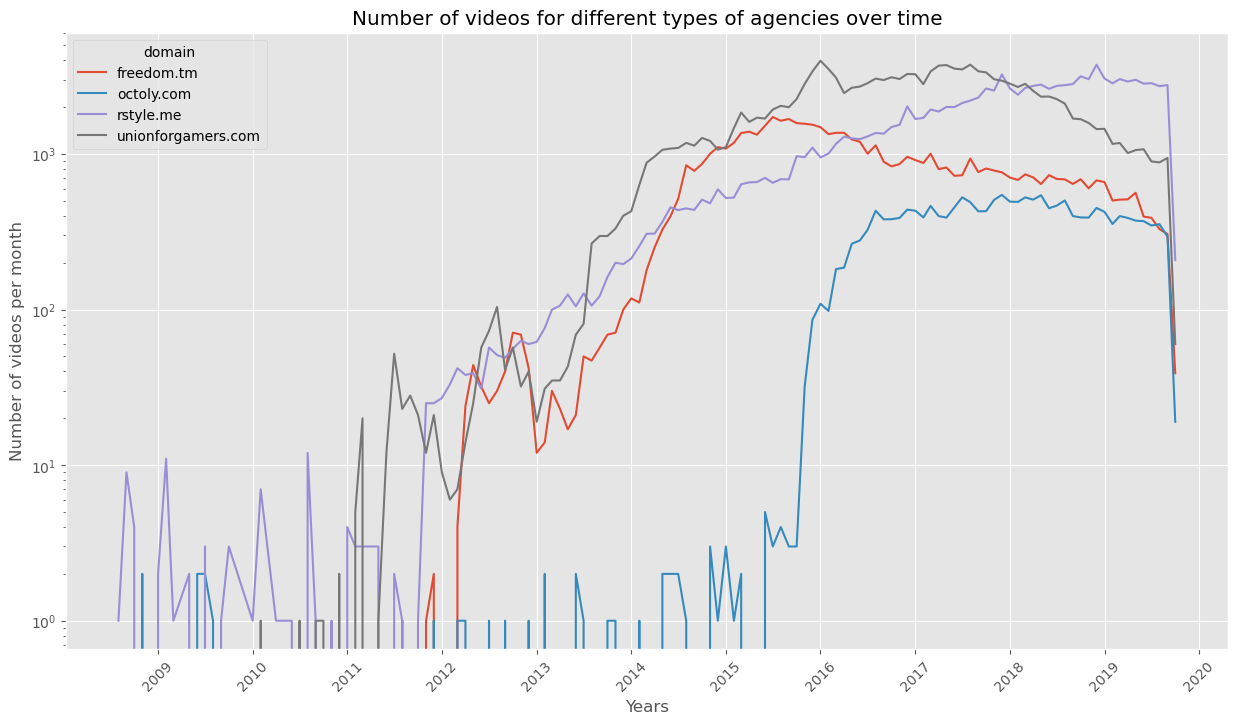

In [16]:
videos_agencies.plot.line(figsize=(15, 8))
plt.title("Number of videos for different types of agencies over time")
plt.xlabel("Years")
plt.ylabel("Number of videos per month")
plt.yscale("log")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.show()

In [17]:
categories = (videos
        .filter(videos.is_sponsored)
        .pandas_api()
        .groupby(['month', "domain_category"])
        .size()
        .reset_index()
        .sort_index()
        .rename(columns={0: "count"})
).spark.persist()
categories.dtypes

month              object
domain_category    object
count               int64
dtype: object

In [18]:
categories = categories.pivot(index='month', columns='domain_category', values='count').sort_index().fillna(0)
categories.head(10)

domain_category,Agency,Application,Beauty,Book,Crypto,Education,Entertainment,Fashion,Finance,Food Drink,Media,Medical,Music,Photo,Real Estate,Religion,Service,Shop,Shorten,Social Media,Sport,Streaming,Technology,Travel,Vehicle,Video Game,YCW
month,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-12-01,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2006-03-01,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2006-04-01,5,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,3,0,0,0,0,0,0,0,0,0
2006-05-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0
2006-06-01,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
2006-07-01,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
2006-08-01,43,4,0,0,0,0,0,0,0,7,0,0,2,0,0,0,0,28,0,0,0,0,0,0,0,0,0
2006-09-01,67,9,0,0,0,0,0,0,0,0,0,3,8,0,0,0,0,27,0,0,0,0,0,0,0,0,0
2006-10-01,42,7,0,0,0,0,0,1,0,5,0,4,12,0,0,0,0,28,0,0,0,0,0,0,0,0,0


In [31]:
top_sponsored = categories.sum(axis=0).sort_values(ascending=False)
# We set the above Series' index order as the order of the columns of our dataframe
categories_top_sponsored = categories.reindex(columns=top_sponsored.index.to_list())
top_sponsored

C:\spark\spark-3.3.1-bin-hadoop3\python\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning: `to_list` loads all data into the driver's memory. It should only be used if the resulting list is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


domain_category
Application      2879138
Agency           2340121
Shop              956026
Video Game        665263
Technology        588092
Music             397657
Fashion           365171
Beauty            300179
Education         152406
Service           109526
Social Media       79017
Food Drink         78563
Crypto             58346
Book               54227
Travel             32801
Media              30168
Shorten            27600
Sport              26897
Streaming          22887
Vehicle            21940
Finance            21619
Entertainment      17115
Medical            14945
Photo              10175
Real Estate        10035
YCW                 5990
Religion            4798
dtype: int64

In [32]:
categories_top_sponsored.head()

domain_category,Application,Agency,Shop,Video Game,Technology,Music,Fashion,Beauty,Education,Service,Social Media,Food Drink,Crypto,Book,Travel,Media,Shorten,Sport,Streaming,Vehicle,Finance,Entertainment,Medical,Photo,Real Estate,YCW,Religion
month,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-12-01,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2006-03-01,6,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2006-04-01,0,5,3,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2006-05-01,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2006-06-01,2,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
cmap = cm.get_cmap('tab20').copy()
cmap.set_over("whitesmoke")

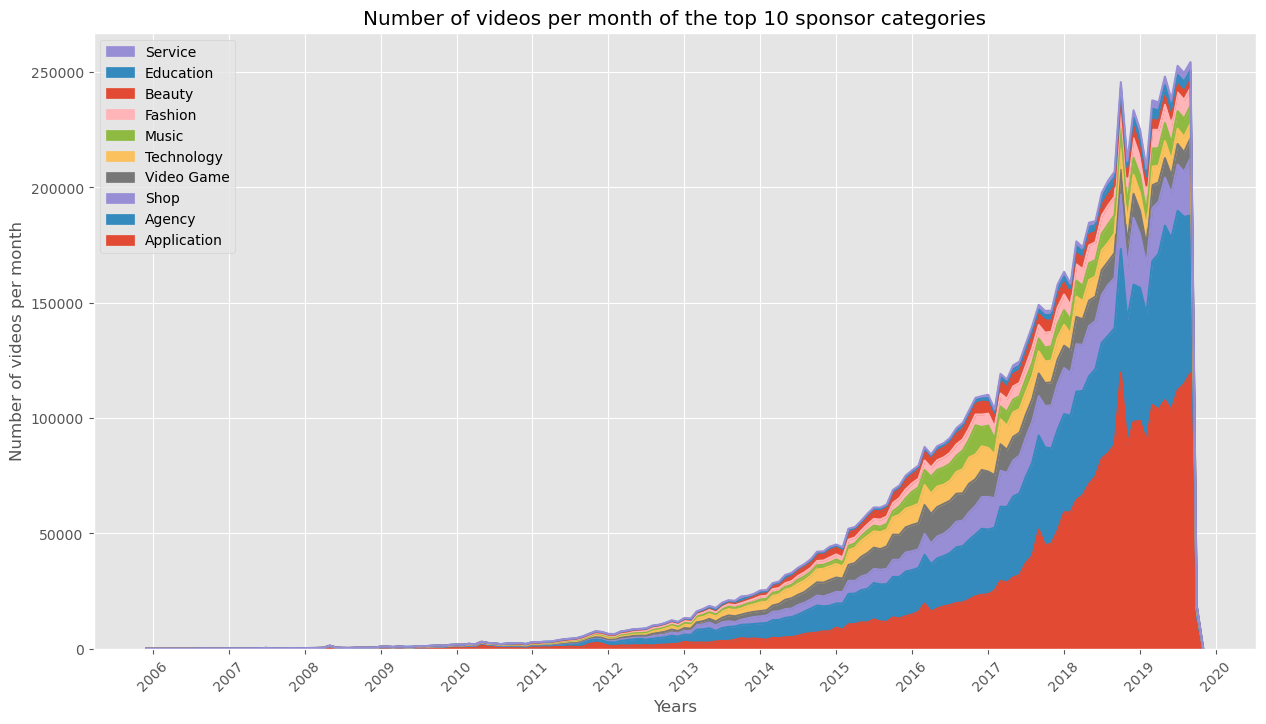

In [96]:
# Do a stacked plot instead of line plot to see the different categories
categories_top_sponsored.iloc[:,:10].spark.persist().plot.area(figsize=(15, 8), colormap=cmap)
plt.title("Number of videos per month of the top 10 sponsor categories")
plt.xlabel("Years")
plt.ylabel("Number of videos per month")
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])
plt.show()

We can see a strange peak by the end of 2018.

In [37]:
# Regroup all columns of categories_top_sponsor from the 11th to the last one into a single column called "others" by summing them
others = categories_top_sponsored.iloc[:,11:].sum(axis=1)
categories_top_sponsored_others: ps.DataFrame = categories_top_sponsored.iloc[:,:10].join(others, on="month").rename(columns={0: "Others"})
categories_top_sponsored_others.head()

,Application,Agency,Shop,Video Game,Technology,Music,Fashion,Beauty,Education,Service,Others
month,,,,,,,,,,,
2005-12-01,0,0,0,0,0,1,0,0,0,0,1
2006-03-01,6,0,1,0,0,0,0,0,0,0,0
2006-04-01,0,5,3,0,0,2,0,0,0,0,0
2006-05-01,0,0,3,0,0,0,0,0,0,0,0
2006-06-01,2,4,2,0,0,0,0,0,0,0,0


In [146]:
categories_ratios = categories_top_sponsored_others.apply(lambda x: x / x.sum(), axis=1).spark.persist()

C:\spark\spark-3.3.1-bin-hadoop3\python\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning: If the type hints is not specified for `apply`, it is expensive to infer the data type internally.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


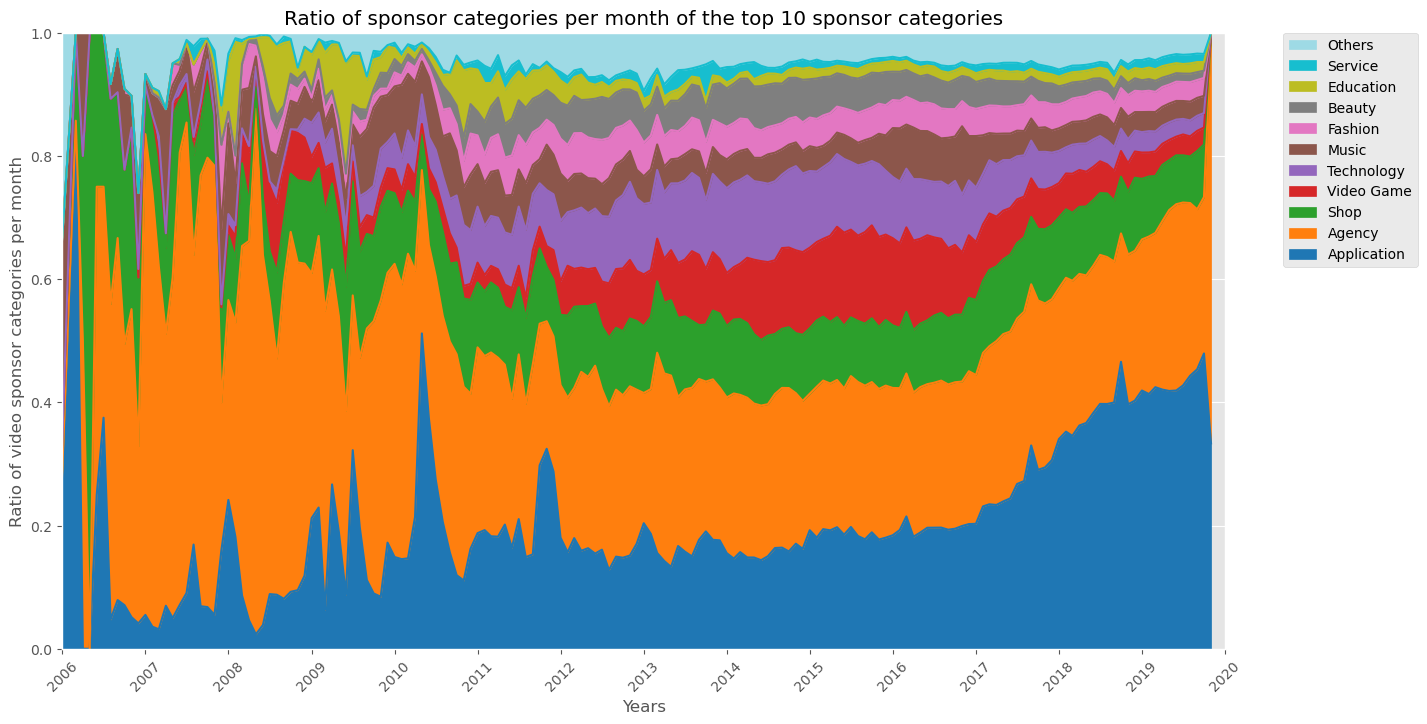

In [147]:
# Normalize each line by the total number of videos and plot the result
categories_ratios.plot.area(figsize=(15, 8), colormap=cmap)
plt.title("Ratio of sponsor categories per month of the top 10 sponsor categories")
plt.xlabel("Years")
plt.ylabel("Ratio of video sponsor categories per month")
plt.ylim(0, 1)
plt.xlim("2006-01-01", "2020-01-01")
# Put the legend outside of the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# Revert the order of the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)
plt.show()

C:\spark\spark-3.3.1-bin-hadoop3\python\pyspark\pandas\utils.py:975: PandasAPIOnSparkAdviceWarning: If the type hints is not specified for `apply`, it is expensive to infer the data type internally.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


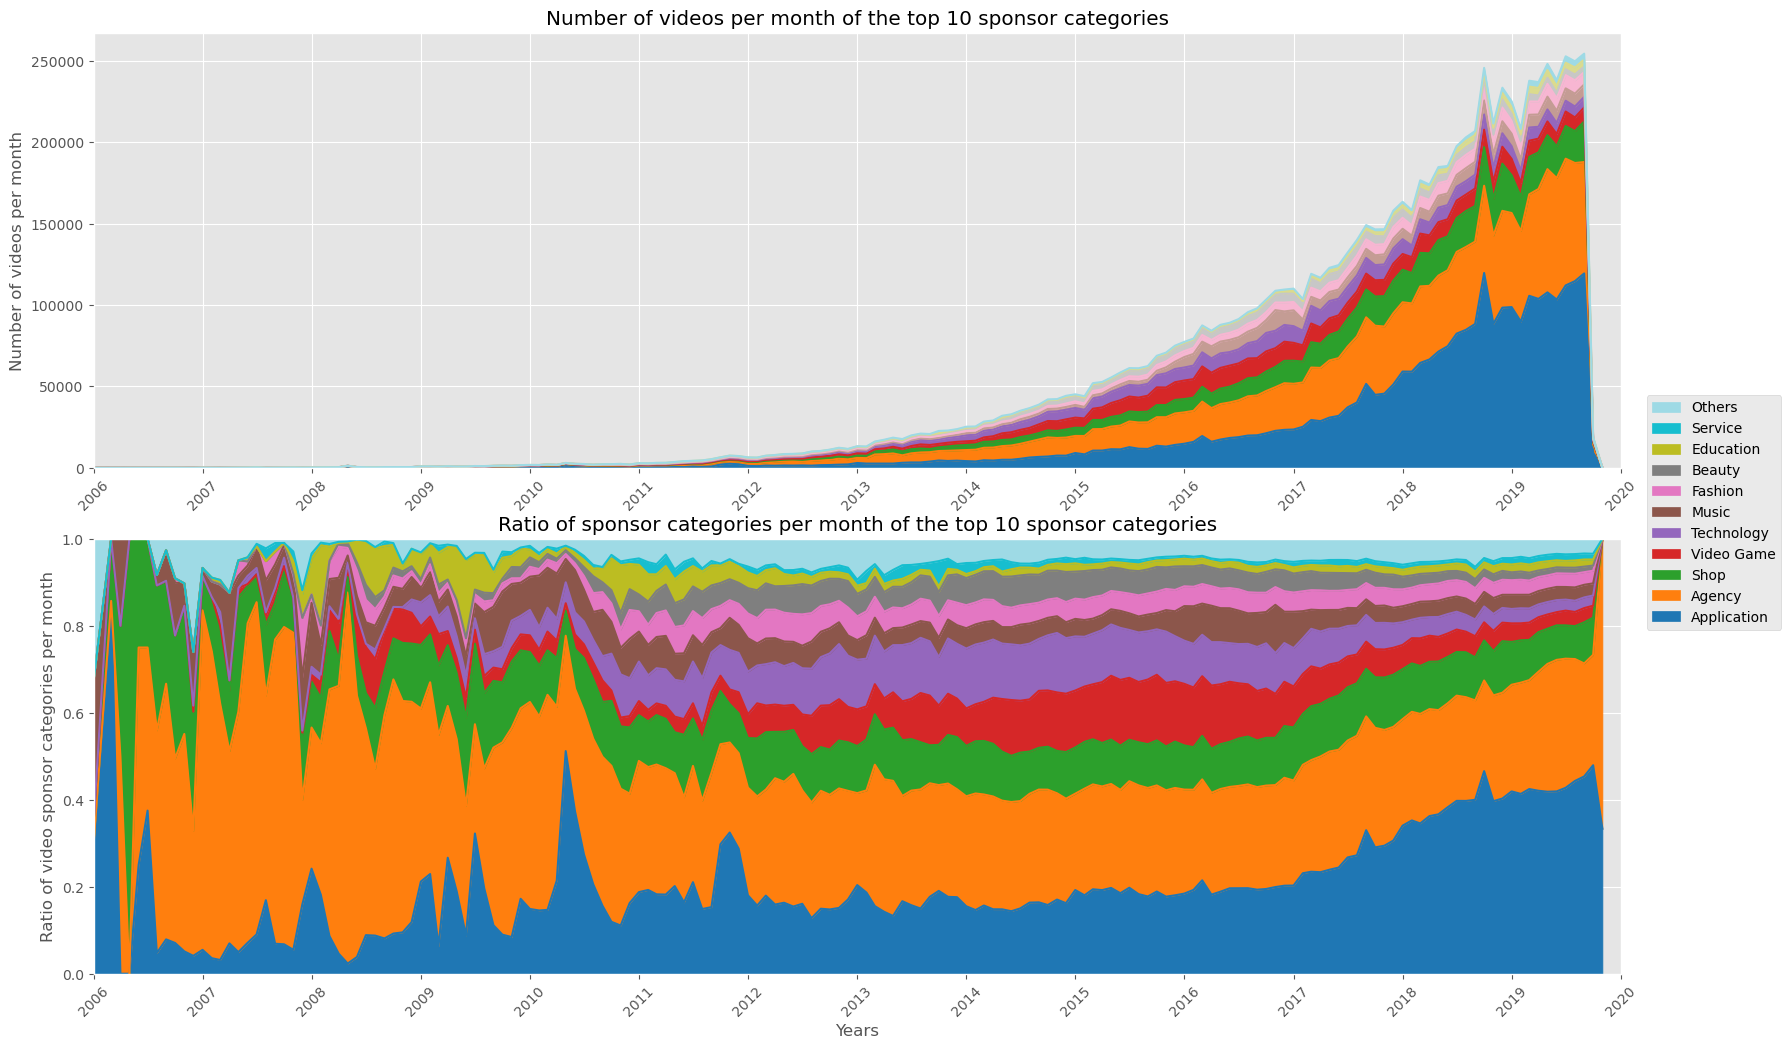

In [148]:
# Create a plot of 2 subplots of the plots above
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))
fig.tight_layout(h_pad=3.0)

# Plot the number of videos per month of the top 10 sponsor categories
# Do a stacked plot instead of line plot to see the different categories
categories_top_sponsored.iloc[:,:10].plot.area(ax=ax1, colormap=cmap)
ax1.set_title("Number of videos per month of the top 10 sponsor categories")
# remove the xlabel of the first plot
ax1.set_xlabel(None)
ax1.set_ylabel("Number of videos per month")
ax1.set_xlim("2006-01-01", "2020-01-01")
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.tick_params(axis='x', labelrotation=45)
ax1.get_legend().remove()

categories_top_sponsored_others.apply(lambda x: x / x.sum(), axis=1).plot.area(ax=ax2, colormap=cmap)
ax2.set_title("Ratio of sponsor categories per month of the top 10 sponsor categories")
ax2.set_xlabel("Years")
ax2.set_ylabel("Ratio of video sponsor categories per month")
ax2.set_ylim(0, 1)
ax2.set_xlim("2006-01-01", "2020-01-01")
# Put the legend outside of the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# Revert the order of the legend
handles, labels = ax2.get_legend_handles_labels()
#ax2.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.tick_params(axis='x', labelrotation=45)
ax2.get_legend().remove()

# Put legend outside of the plot to the right
fig.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=0)

plt.show()

In [159]:
categories_ratios.index.astype("datetime64[ns]", inplace=True).dtype

TypeError: astype() got an unexpected keyword argument 'inplace'